In [1]:
# Import modules
import pandas as pd
import pandas_datareader 
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:

# Specify the time peiod for data collection
start_date = '2017-04-15'
end_date = '2022-04-15'

# List the ticker symbols of the portfolio stocks
tickers = ['BAC', 'BMY', 'BX', 'CC', 'CI', 'CSCO', 'DE', 'HD', 'IFF', 'IHG', 'JNJ', 'JPM', 'LMT', 'MCD',
           'MRK', 'NVS', 'NYT', 'PSO', 'RBGLY', 'SAP', 'SBUX', 'SHEL', 'STT', 'TXN', 'UPS', 'VZ', 'WFC', 'WLY', 'WTW', 'YORW']

# Create a dataframe to hold the stock prices
data = pd.DataFrame()

# Loop through the ticker symbols and obtain the weekly closing price for each symbol
# from Yahoo Finance
for t in tickers:
    data[t] = pandas_datareader.yahoo.daily.YahooDailyReader(t, interval='w' , start=start_date, end=end_date).read()['Adj Close']

#data.head()
    

In [3]:
# Compute the weekly portfolio value as the average price for all stocks.
data['Avg'] = data.mean(1)
data.tail()

,BAC,BMY,BX,CC,CI,CSCO,DE,HD,IFF,IHG,...,SHEL,STT,TXN,UPS,VZ,WFC,WLY,WTW,YORW,Avg
Date,,,,,,,,,,,,,,,,,,,,,
2022-03-14,42.900002,70.499779,122.849998,30.090000,241.160004,55.589321,412.099426,340.739990,128.321213,69.510757,...,51.160000,88.379677,180.100006,219.779999,50.188873,51.419998,54.892738,235.204895,43.090000,130.278788
2022-03-21,43.730000,72.743225,123.800003,32.029999,243.580002,54.596123,435.340179,310.679993,128.688889,68.967468,...,55.590000,89.969772,184.899994,215.350006,50.663097,52.560001,54.177265,237.188202,44.700001,131.704883
2022-03-28,40.900002,73.279266,128.130005,32.259998,246.250000,55.281429,415.740112,301.890015,134.330002,68.078461,...,55.720001,85.278984,182.080002,206.639999,51.492992,48.709999,54.535000,236.659988,43.669998,130.462405
2022-04-04,39.669998,77.769997,114.970001,32.299999,257.899994,53.910812,418.299988,311.109985,124.269997,64.949997,...,56.090000,84.169998,174.110001,190.970001,52.886028,48.730000,52.130211,241.050003,43.299999,130.246595
2022-04-11,37.570000,77.510002,112.980003,33.799999,259.209991,51.169998,436.750000,304.519989,125.430000,68.500000,...,57.110001,75.809998,173.660004,188.020004,53.830002,46.349998,53.619999,234.149994,41.520000,129.620666


In [4]:
#Calculate the monthly returns based on the weekly prices
y = data['Avg'].resample('M') \
 .last() \
 .pct_change() \
 .dropna()
#Format the date to yyyy-mm 
y.index = y.index.strftime('%Y-%m')
y.name = 'rtn'
#y.head()

In [5]:
#Download the Fama-French benchmark data from the French Data Library
#Unzip the data and load it as a csv file
factor_df = pd.read_csv('F-F_Research_Data_Factors.csv',
 skiprows=3)
#Filter and retain the monthly data
STR_TO_MATCH = ' Annual Factors: January-December '
indices = factor_df.iloc[:, 0] == STR_TO_MATCH
start_of_annual = factor_df[indices].index[0]
factor_df = factor_df[factor_df.index < start_of_annual]

In [6]:
#Remane dataframe columns
factor_df.columns = ['date', 'mkt', 'smb', 'hml', 'rf']
factor_df['date'] = pd.to_datetime(factor_df['date'],
 format='%Y%m') \
 .dt.strftime("%Y-%m")
#Set the date as an index
factor_df = factor_df.set_index('date')
factor_df = factor_df.loc[start_date:end_date]

In [7]:
#Merge the portfolio returns and benchmark datafames
ff_data = factor_df.join(y)
ff_data = ff_data.apply(pd.to_numeric)
#Compute the portfolio's excess returns
ff_data['excess_rtn'] = ff_data.rtn - ff_data.rf

## Introduction

The Fama–French three-factor model is an expansion of the capital assets pricing model (CAPM) that utilizes statistical modeling to evaluate the returns of a portfolio or asset. In particular, the model analyzes three factors, namely excess market returns(mkt), excess returns of small-cap stocks relative to large-cap stocks(smb), and excess returns of value stocks over growth stocks (hml). The model therefore seeks to control for the outperformance of small-cap and value stocks in order to explain the performance of a portfolio.  The model assumes that there is a linear relationship between portfolio returns, mkt, smb and hml that is express as:

<i> r = R<sub>f</sub> + β<sub>1</sub>(R<sub>m</sub> - R<sub>f</sub>) +  β<sub>2</sub>(smb) +  β<sub>3</sub>(hml) + ε </i>


<i>r</i> is is the expected rate of return, <i>(R<sub>m</sub> - R<sub>f</sub>) </i> is the market premium caluculated as the difference between market return <i>(R<sub>m</sub>)</i> and the risk free rate <i>(R<sub>f</sub>)</i>, and ε is the market risk. The model estimates the coefficients of each factor <i>(β)</i> to obtain the expected return rate of the portfolio.

## Data
We estimate the Fama–French three-factor model that can be used to explain the returns of a diversified portfolio comperising of 30 stocks from different industries. The portfolio is equally weighted consisting of weekly adjusted closing prices for each of the selected stocks over a 5-year period from 15 April, 2017 to 15 April 2022. The model analyzes four variables, which include portfolio excess returns, excess market returns (mkt), excess returns on small market capitalization stocks relative to large market capitalization stocks (smb), and excess return on value stocks relative to growth stocks (hml). Data used to calculate portfolio returns was obtained from Yahoo Finance, while Fama–French benchmark data was obtained from the <a href="https://mba.tuck.dartmouth.edu/pages/faculty/ken.french/data_library.html">French data library</a>. A summary of the data is shown below along with the scatter plots of the dependent variable (excess portfolio returns) relative to the
independent variables (mkt, sbm, hml).

In [8]:
#Display summary statistics
print (ff_data.describe(include='all'))

             mkt       smb        hml         rf        rtn  excess_rtn
count  58.000000  58.00000  58.000000  58.000000  58.000000   58.000000
mean    1.218448  -0.06931  -0.304655   0.086207   0.011034   -0.075173
std     4.847682   2.81541   4.089884   0.075622   0.045231    0.094894
min   -13.380000  -5.87000 -14.020000   0.000000  -0.127356   -0.267573
25%    -0.090000  -2.26500  -2.265000   0.010000  -0.010144   -0.149721
50%     1.780000  -0.36000  -0.620000   0.090000   0.011422   -0.074092
75%     3.347500   1.91500   1.715000   0.150000   0.035875   -0.005843
max    13.650000   7.18000  12.790000   0.210000   0.129058    0.119058


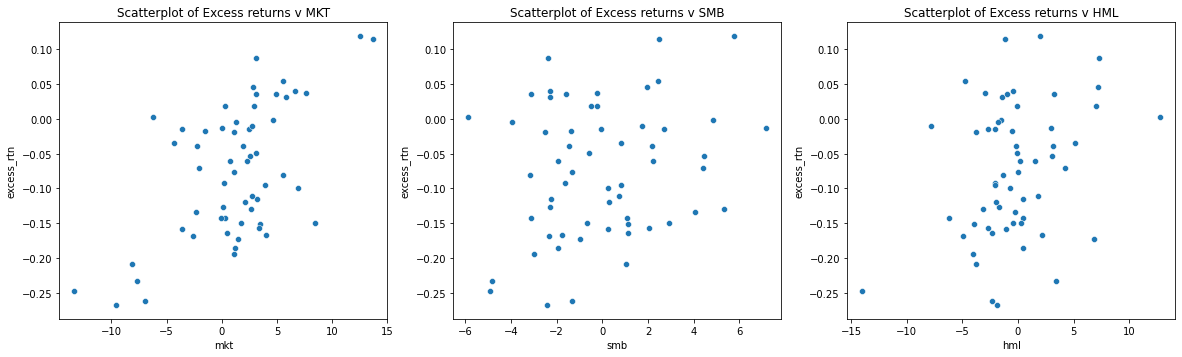

In [9]:
# Plotting scatterplots for the variables
fig = plt.figure(figsize=(20,12))
#  subplot #1
plt.subplot(231)
plt.title('Scatterplot of Excess returns v MKT')
sns.scatterplot(data = ff_data, x = 'mkt', y = 'excess_rtn')
#  subplot #2
plt.subplot(232)
plt.title('Scatterplot of Excess returns v SMB')
sns.scatterplot(data = ff_data, x = 'smb', y = 'excess_rtn')
#  subplot #3
plt.subplot(233)
plt.title('Scatterplot of Excess returns v HML')
sns.scatterplot(data = ff_data, x = 'hml', y = 'excess_rtn')

plt.show()

The excess portfolio returns have a moderate positive linear relationship with excess market returns as evidenced by the positive correlation of the data points. There is also a weak linear relationship between excess portfolio returns and excess small-cap returns since there is a general upward pattern in the data points. However, there is no clear relationship beween excess portfolio returns and excess value stock returns, since most of the excess potfolio returns appear to be clustered around the hml value of zero. The scatter plots indicate that among the three factors, excess market returns are the strongest predictors of excess portfolio returns.

## OLS
### Initial Results

In [10]:
#Use OLS regression to estimate the Fama-French Three-Factor Model
ff_model = smf.ols(formula='excess_rtn ~ mkt + smb + hml',
 data=ff_data).fit()
print(ff_model.summary())

                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     13.46
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           1.13e-06
Time:                        14:50:50   Log-Likelihood:                 70.985
No. Observations:                  58   AIC:                            -134.0
Df Residuals:                      54   BIC:                            -125.7
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0867      0.010     -8.592      0.0


* H<sub>0</sub> : β<sub>1</sub> = β<sub>2</sub> = β<sub>3</sub> = 0;

According to the null hypothesis, the predictor variables do not have a statistically significant relationship with the excess portfolio returns, y. The results however reject the null hypothesis since two of the coefficients are not equal to zero.
The result summary show that market risk premium (0.01, <i>p</i> < 0.01) and value stock excess returns (0.01, <i>p</i> < 0.05) have a statistically significant relationship with the portfolio excess returns. The SMB (0.001, <i>p</i> = 0.89) however does not have a significant relationship since as the <i>P</i>-value is higher than the 0.05 significance level. The the sign of all the coefficients is positive, which is consistent with the theoretical model. The results therefore indicate that exceess market returns and excess value stock returns have a strong positive relationship with portfolio returns and are critical factors that affect the returns of the portfolio.

The F-statistic (13.46) is greater than the F-citical (0.00) which indicates that the model is significant, implying that the independent vaiables have a signiicant combined effect on the portfolio excess returns. We can therefore reject the null hypothesis that the predictor variables do not have a statistically significant relationship with the excess portfolio returns. The R<sup>2</sup> of 0.428 implies that 42.8% of the variation in the excess portfolio returns can be explained by the variations in MKT, SMB and HML. The adjusted R<sup>2</sup> (0.396) however indicates that the variables are not effective predictors of the portfolio returns since they are only able to fit 39.6% of the returns.

### OLS Diagnostics

In [11]:
#Compute mean of residuals is zero
print ('The mean of residuals is %.3f'%ff_model.resid.mean())

The mean of residuals is -0.000


The mean or expectation of residuals is zero hence <i>E(u<sub>t</sub>)</i> = 0 is satisfied. Residuals represent the difference between the data point and the regression line and therefore the assumption is significant since it implies that the regression line is the best fit. If the assumption is not satified, it is indicative of spuious results since it suggests that the predicted values could be significantly higher or lower than the observed values.

In [12]:
from statsmodels.compat import lzip
import statsmodels.stats.api as sms

#Bresuch-Pagan test
names = ['Lagrange multiplier statistic', 'p-value',
        'f-value', 'f p-value']
test = sms.het_breuschpagan(ff_model.resid, ff_model.model.exog)

lzip(names, test)

[('Lagrange multiplier statistic', 2.347503519885466),
 ('p-value', 0.5034816242406481),
 ('f-value', 0.7592662689091908),
 ('f p-value', 0.5218764257601985)]

* H<sub>0</sub>: Homoscedasticity is present

The Lagrange multiplier statistic is 2.35 with a corresponding <i>p</i>-value is 0.503. Since the p-value is not less greater 0.05, we fail to reject the null hypothesis and therefore <i>var(u<sub>t</sub>) = σ<sup>2</sup> < ∞</i> is satisfied since there is no evidence of heteroscedasticity in the regression model. OLS regression assumes that the residuals have a constant variance and therefore if the assumption is not satisfied, it is indicative of spurious results and therefore incorrect conclusions.

In [13]:
import statsmodels.stats.diagnostic as dg

#Breusch-Godfrey test at order p = 4
print(dg.acorr_breusch_godfrey(ff_model, nlags=4))

(48.45322911568293, 7.592310376718832e-10, 63.44190839868097, 5.634552882039302e-19)


* H<sub>0</sub>: There is no autocorrelation at any order <= <i>p</i>

The second value represents the <i>p</i>-value and since it is less than 0.05, we reject the null hypothesis and conclude that autocorrelation exists within the residuals at an order less than or equal to 4. <i>cov(u<sub>i</sub>, u<sub>j</sub>)</i> = 0 is not satisfied implying that the regression model is biased since it is underestimating the sampling variance and therefore does not inefficiently estimate the response variable.

In [14]:
#Newey-West correction of the standard errors
#Create a new OLS model co_model
co_model = ff_model.get_robustcov_results(cov_type='HAC',maxlags=4)
print (co_model.summary())


                            OLS Regression Results                            
Dep. Variable:             excess_rtn   R-squared:                       0.428
Model:                            OLS   Adj. R-squared:                  0.396
Method:                 Least Squares   F-statistic:                     28.41
Date:                Fri, 22 Apr 2022   Prob (F-statistic):           3.68e-11
Time:                        14:50:55   Log-Likelihood:                 70.985
No. Observations:                  58   AIC:                            -134.0
Df Residuals:                      54   BIC:                            -125.7
Df Model:                           3                                         
Covariance Type:                  HAC                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0867      0.018     -4.732      0.0

* H<sub>0</sub> : β<sub>1</sub> = β<sub>2</sub> = β<sub>3</sub> = 0;

Similar to the initial regression, the OLS results of the corrected regression reject the null hypothesis since two of the coefficients are not equal to zero. The result summary show that mkt (0.01, <i>p</i> < 0.01) and hml (0.01, <i>p</i> < 0.05) have a statistically significant relationship with the portfolio excess returns. The smb (0.001, <i>p</i> = 0.87)  does not have a significant relationship and the the sign of all the coefficients is positive, which is consistent with the theoretical model. The results are consistent with the findings of the initial model, with only the <i>p</i>-value of smb decreasing slightly from the initial model.

The F-statistic (28.41) is greater than the F-citical (0.00) which indicates that the independent vaiables have a signiicant combined effect on the portfolio excess returns. We can therefore reject the null hypothesis. The R<sup>2</sup> and adjusted R<sup>2</sup> of the corrected model are unchanged from the inital model.

In [15]:
#Jarque-Bera test
name = ['Jarque-Bera', 'Chi^2 two-tail prob.', 'Skew', 'Kurtosis']
test = sms.jarque_bera(co_model.resid)

lzip(name, test)


[('Jarque-Bera', 2.9365189758583425),
 ('Chi^2 two-tail prob.', 0.23032602173731817),
 ('Skew', -0.26774371265261876),
 ('Kurtosis', 2.0364832551039167)]

H<sub>0</sub> : skewness = 0 and kurtosis = 3

The error terms are normally distributed since the <i>p</i>-value Jarque-Bera test is greater than 0.05 and therefore we cannot reject H<sub>0</sub>. If this assumption is not satisfied, the model results could be incorrect since it implies there is frequent significant difference between the predicted and observed data points.

Text(0.5, 1.0, 'Correlation Heatmap')

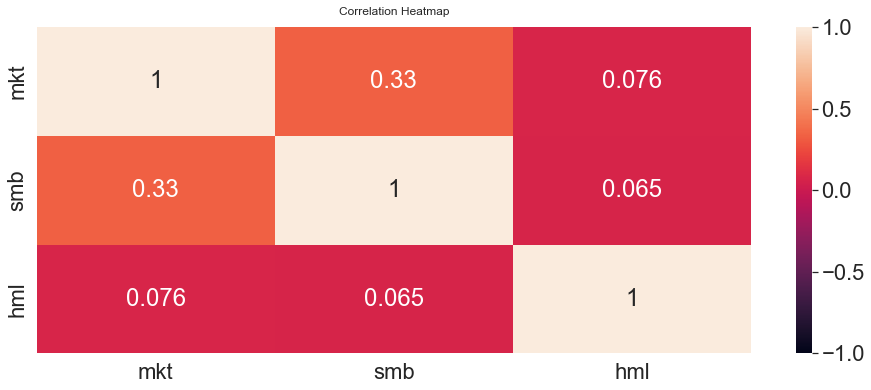

In [16]:
#Plot a correlation matrix
ax = plt.figure(figsize=(16, 6))
sns.set(font_scale=2)
# Extract independent variables
cor_df =  ff_data.filter(['mkt','smb','hml'], axis=1)
heatmap = sns.heatmap(cor_df.corr(), vmin=-1, vmax=1, annot=True)
heatmap.set_title('Correlation Heatmap', fontdict={'fontsize':12}, pad=12)

There is no evident near-multicollinearity since one of the independent variables have an an almost linear relationship between them. The highest correlation is between smb and mkt (0.33) which is below 50%.

In [17]:
#RESET Ramsey test
from statsmodels.stats.outliers_influence import reset_ramsey
reset_ramsey(co_model, degree = 4)

<class 'statsmodels.stats.contrast.ContrastResults'>
<F test: F=1.332117936509163, p=0.2741886047855476, df_denom=51, df_num=3>

* H<sub>0</sub> : β<sub>1</sub> = β<sub>2</sub> = β<sub>3</sub> = 0;

The p-value for the F-stat is 0.27 which is greater than the 0.05 significance level. Therefore we cannot reject the null hypothesis of correct specification. This is an indication that the model has the correct functional form iand is therefore there are no omitted variables.

In [26]:
import statsmodels.api as sm
import scipy

#define response variable
y1 = ff_data['excess_rtn']

#Reduce predictor variables to only significant variables
x1 = ff_data[['mkt', 'hml']]

#Add constant to predictor variables
x1 = sm.add_constant(x1)

#fit reduced regression model
reduced_model = sm.OLS(y1, x1).fit()

#calculate log-likelihood of model
reduced_ll = reduced_model.llf
full_ll = ff_model.llf

#Compute likelihood ratio Chi-Squared 
LR_statistic = -2*(reduced_ll-full_ll)

#Compute p-value of  Chi-Squared using 1 degree of freedom 
# calculated as the difference between the predictors in the 
# reduced and full models
p_val = scipy.stats.chi2.sf(LR_statistic, 1)

print(p_val)

0.881234236539463


H<sub>0</sub>: The full model and the reduced model fit the data. 

Since the <i>p</i>-value is greater than 0.05 we cannot reject the null hypothesis and can conclude that the reduced model offers a better fit for the data. Model stabiity i significant since it ensures there is no heteroscedasticity in the model. if the condition is not satisfied it implies that that OLS estimators are not the best fit and are therefore biased.